<a href="https://colab.research.google.com/github/dlabate/SPACe/blob/main/SPACe_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running SPACe in colab with a GPU


# installation

Install SimpleITK, pyclesperanto, and cellpose -- by default the torch GPU version is installed in COLAB notebook.



In [ ]:
!pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest
!pip install pyclesperanto_prototype
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!apt-get install -y pocl-opencl-icd

Looking in links: https://github.com/SimpleITK/SimpleITK/releases/tag/latest
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 941.9/941.9 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv

# Clone GitHub SPACe repository

In [ ]:
# Clone the GitHub repository
!git clone https://github.com/MichelaMarini/CellP_ex.git

# Navigate to the cloned directory
%cd CellP_ex

Cloning into 'CellP_ex'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 143 (delta 26), reused 0 (delta 0), pack-reused 99
Receiving objects: 100% (143/143), 1.92 MiB | 14.67 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/CellP_ex


import libraries

In [ ]:
import sys

import time
from tqdm import tqdm
from pathlib import Path

import cv2
import random
import numpy as np
import SimpleITK as sitk
from PIL import Image, ImageFilter

import skimage.io as sio
from skimage.measure import label
from skimage.color import label2rgb
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import watershed, expand_labels, find_boundaries, clear_border
from skimage.morphology import disk, erosion, dilation, closing, \
    binary_dilation, binary_erosion, binary_closing, remove_small_objects, convex_hull_image


from cellpaint.steps_single_plate._segmentation import SegmentationPartI, SegmentationPartII
from cellpaint.steps_single_plate.step0_args import Args, \
    load_img, sort_key_for_imgs, get_img_channel_groups, set_mask_save_name


import torch
from cellpose import models
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
# %matplotlib qt

/usr/local/lib/python3.10/dist-packages/pyclesperanto_prototype/_tier0/_device.py:77: UserWarning: No OpenCL device found with RTX in their name. Using pthread-Intel(R) Xeon(R) CPU @ 2.20GHz instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


# Import data

Make sure that the platemap is included inside the image folder. Here, you can mounting your Google Drive and import the data from your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# path to where the data is
camii_server_flav = Path(r"/content/drive/MyDrive/2020_08_11_Stain3_Yokogawa_Results/")
# which experiment
exp_fold = Path(r"BR00115126")

main_path = Path(camii_server_flav)
args = Args(experiment=exp_fold, main_path=main_path, mode="preview").args

Mounted at /content/drive/
self.args.imgs_fold: Jump_Consortium_Datasets_cpgmoa_AssayPlate
self.args.imgs_dir /content/drive/MyDrive/2020_08_11_Stain3_Yokogawa_Results/BR00115126/Jump_Consortium_Datasets_cpgmoa_AssayPlate
self.args.plate_protocol Jump_Consortium_Datasets_cpgmoa_AssayPlate
anchor treatment: dmso   anchor cell-line: u2os   anchor density: 3000   anchor dosage: 0   anchor other: 0
control_treatments:  ['dmso']


# Setting Hyperparameters


In [ ]:
def get_wellid(x, args):
    return sort_key_for_imgs(x, "to_get_well_id", args.plate_protocol)

# change the default arguments to your custom arguments
def set_custom_datasets_hyperparameters(args):
    ##############################################################################
    # intensity rescaling hyperparameters
    args.w1_intensity_bounds = (5, 99.95)
    args.w2_intensity_bounds = (5, 99.95)
    args.w3_intensity_bounds = (5, 99.95)
    args.w4_intensity_bounds = (5, 99.95)
    args.w5_intensity_bounds = (5, 99.95)
    ##########################################################################
    # background correction hyperparameters
    # Set args.bg_sub to True first,
    # if you decide to do background subtraction.
    args.bg_sub = False
    args.w1_bg_rad = 50
    args.w2_bg_rad = 100
    args.w3_bg_rad = 50
    args.w4_bg_rad = 100
    args.w5_bg_rad = 100
    #######################################################################
    # image channels order/index
    # defined during data acquisition set by the investigator/microscope
    args.nucleus_idx = 0
    args.cyto_idx = 1
    args.nucleoli_idx = 2
    args.actin_idx = 3
    args.mito_idx = 4
    #######################################################################
    # hyperparameters/constants used in Cellpaint Step 2
    #options for args.step2_segmentation_algorithm are:
        # 1) "w1=cellpose_w2=cellpose"
        # 2) "w1=pycle_w2=pycle"
        # 3) "w1=cellpose_w2=pycle"
        # 4) "w1=pycle_w2=cellpose"
    args.step2_segmentation_algorithm = "w1=cellpose_w2=cellpose"
    args.cellpose_nucleus_diam = 20
    args.cellpose_cyto_diam = 25
    args.cellpose_batch_size = 64
    args.cellpose_model_type = "cyto2"
    # define the minimum size of segmented objects in each channel
    args.w1_min_size = 400
    args.w2_min_size = 500
    args.w3_min_size = 4
    args.w5_min_size = 300
    #######################################################
    # hyperparameters/constants used in Cellpaint Step 3
    ############################################
    # args.multi_nucleus_dist_thresh decides
    # whether to break down a multi-nucleus cyto mask,
    # into individual cyto masks,
    # based on avg-pairwise distance of all the nucleus
    # inside that cytoplasm
    args.multi_nucleus_dist_thresh = 10
    #######################################
    args.min_nucleoli_size_multiplier = .000001
    args.max_nucleoli_size_multiplier = .999
    args.nucleoli_bd_area_to_nucleoli_area_threshold = .01
    args.w3_local_rescale_intensity_ub = 99.95
    args.w5_local_rescale_intensity_ub = 99.99
    return args

In [ ]:
# update args
args = set_custom_datasets_hyperparameters(args)

In [ ]:
# choose your sample wells from the plate
sample_wellids = ["A01"]
# restrict it to a few images
args.img_filepaths = sorted(filter(
    lambda x: np.isin(get_wellid(x, args), sample_wellids), args.img_filepaths))
args.img_filename_keys, args.img_channels_filepaths, args.N = get_img_channel_groups(args)

In [ ]:
# choose an idx  (index)
idx = 0
# get the path to the 5 channels as a list
img_group = args.img_channels_filepaths[idx]
# get keys
filename_key = args.img_filename_keys[idx]
exp_id, well_id, fov = filename_key[0], filename_key[1], filename_key[2]
# load the 5 channel image
img = load_img(img_group, args)

100%|██████████| 25.3M/25.3M [00:01<00:00, 21.8MB/s]
100%|██████████| 3.54k/3.54k [00:00<00:00, 2.41MB/s]


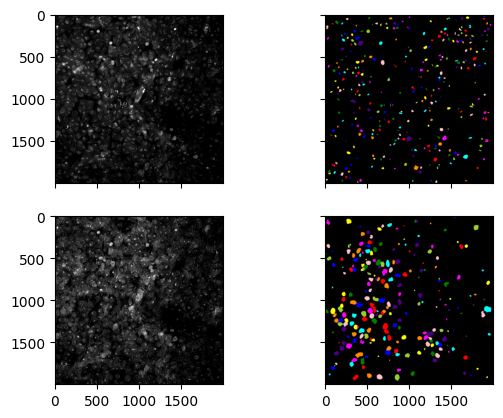

In [ ]:
# run segmentation step 1 to get nucleus mask and cytoplasm mask
cellpaint_segmentation_step1 = SegmentationPartI(args)
w1_mask, w2_mask = cellpaint_segmentation_step1.get_cellpose_masks(
    img_group, filename_key)
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes[0, 0].imshow(img[0], cmap="gray")
axes[0, 1].imshow(label2rgb(w1_mask, bg_label=0), cmap="gray")
axes[1, 0].imshow(img[1], cmap="gray")
axes[1, 1].imshow(label2rgb(w2_mask, bg_label=0), cmap="gray")
# axes[2, 0].axis("off")
plt.show()

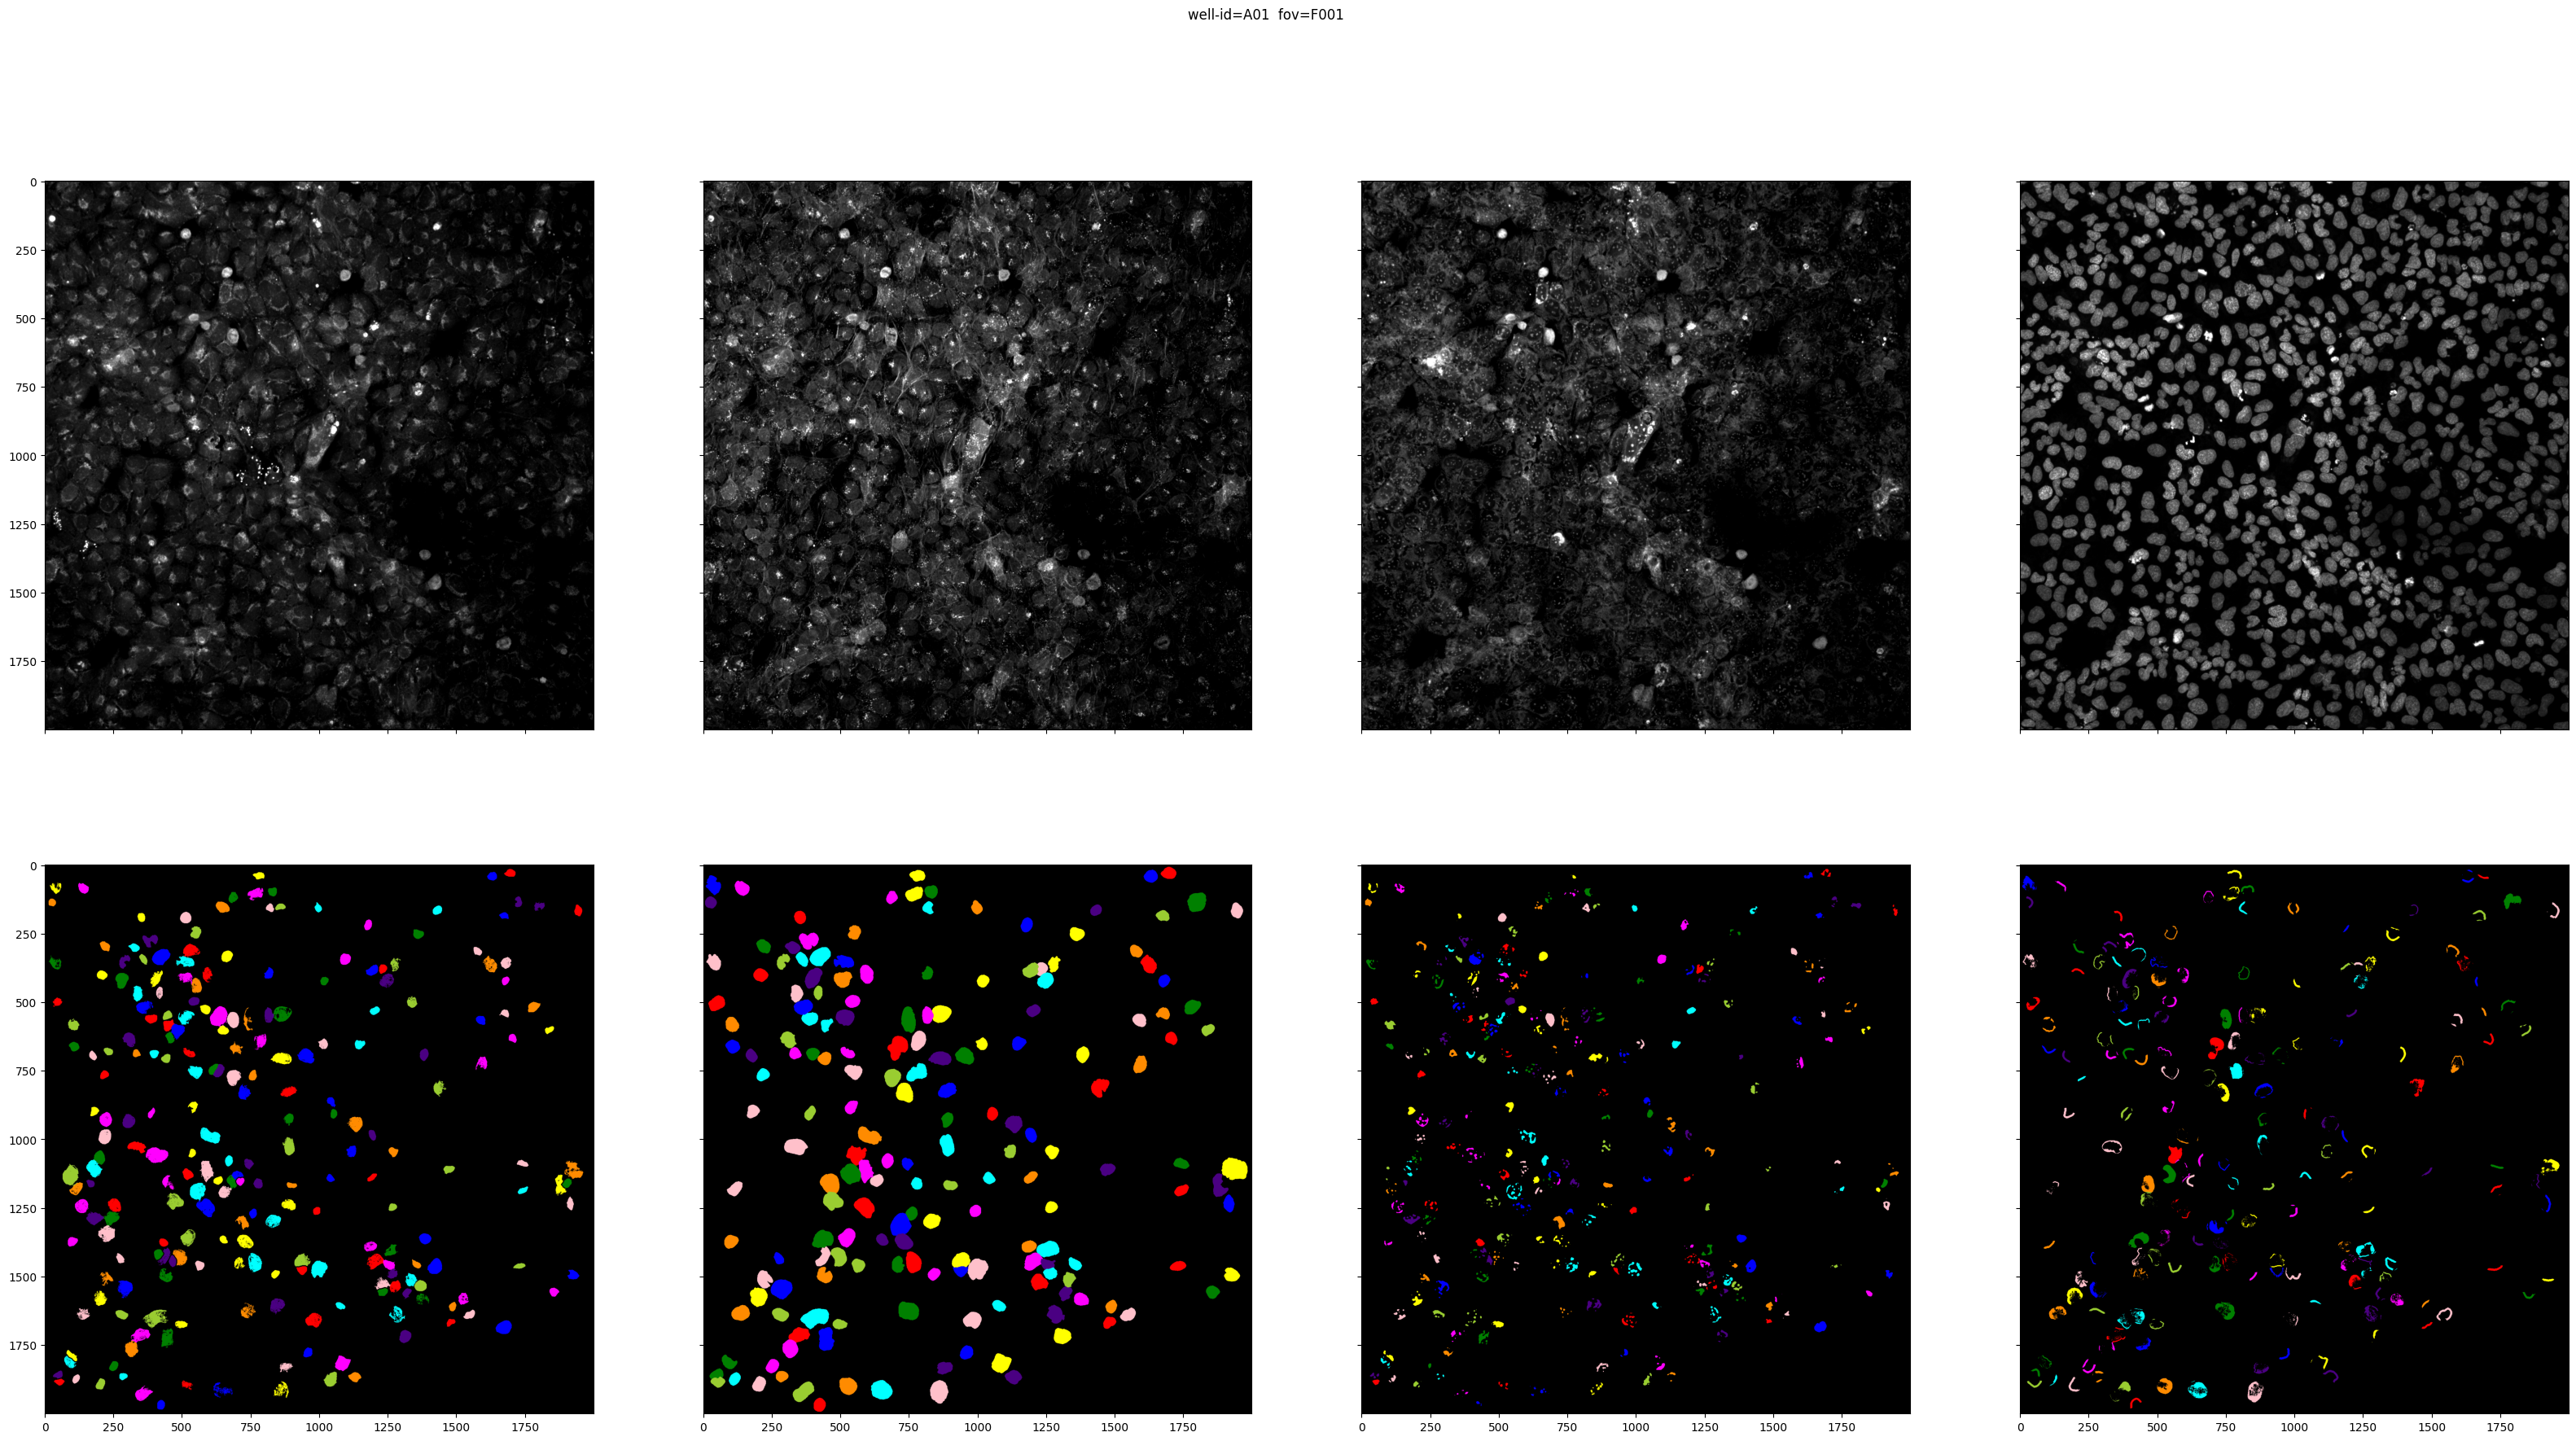

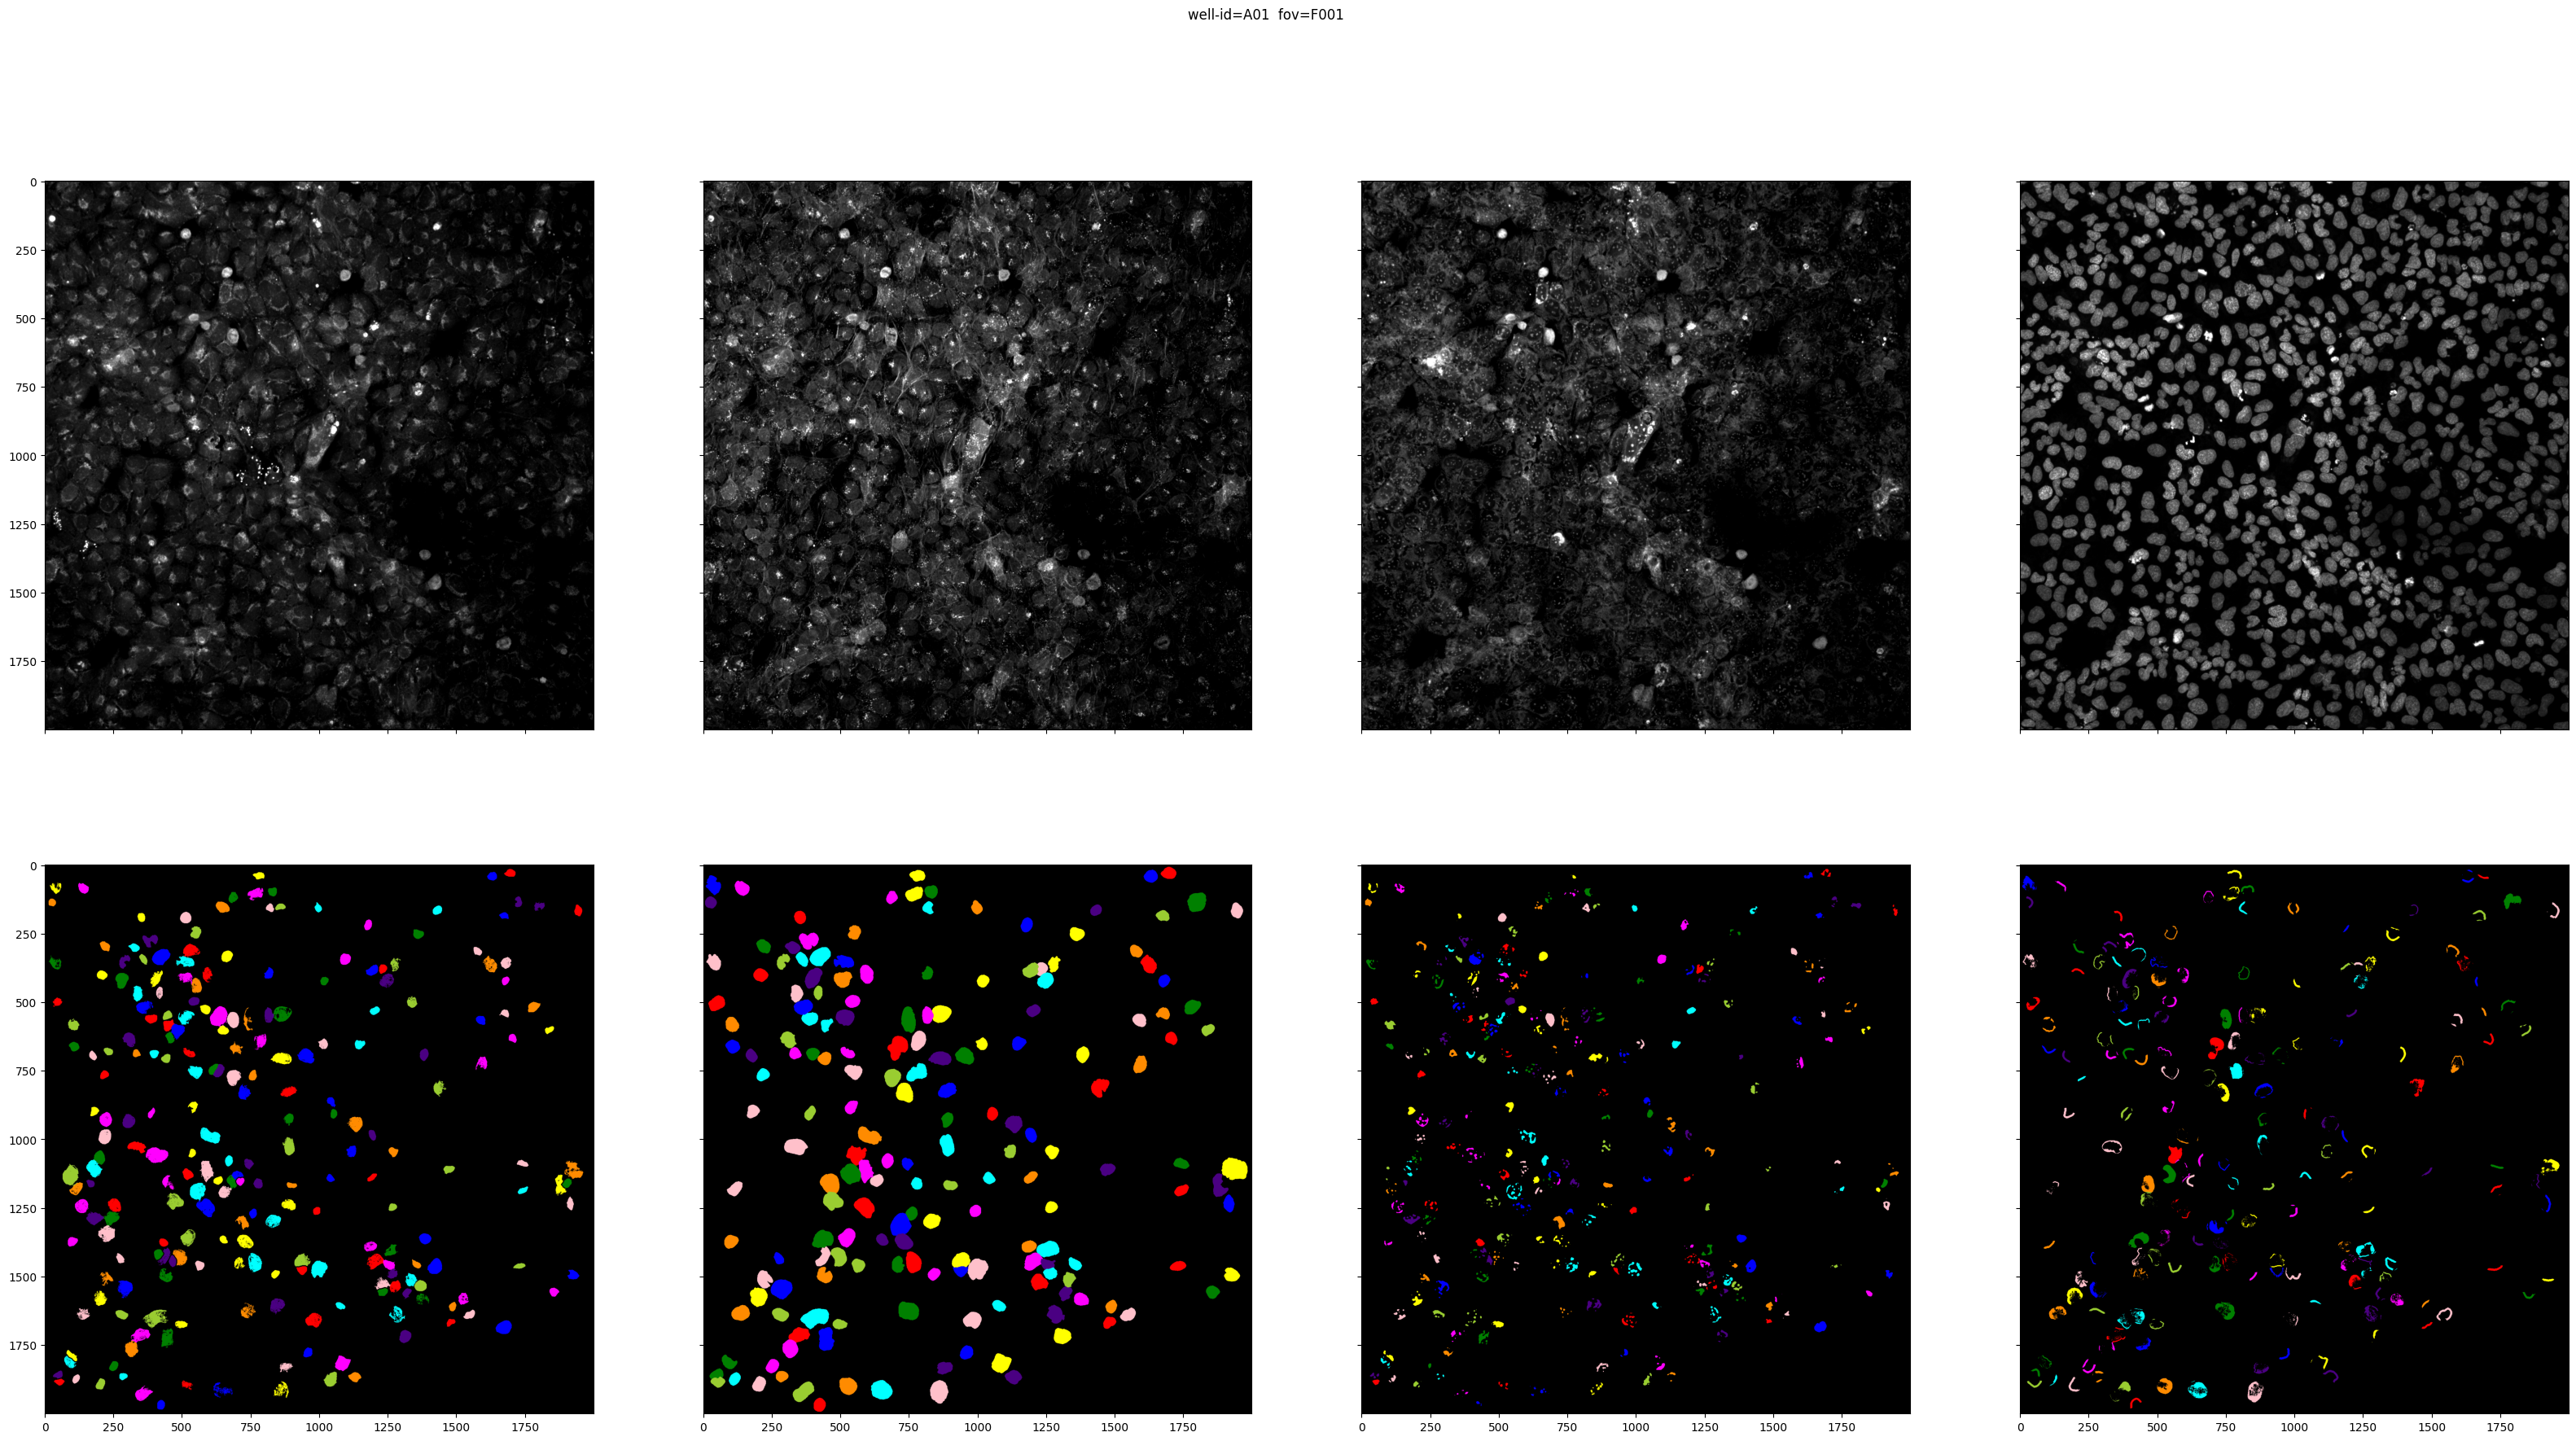

In [ ]:
# run segmentation step 2 to match cytoplasm and nucleus and masks, as well as,
# segment nucleoli and mitocondria masks
cellpaint_segmentation_step2 = SegmentationPartII(args)
w1_mask, w2_mask, w3_mask, w5_mask = cellpaint_segmentation_step2.run_demo(
    img_group, img, w1_mask, w2_mask)

fig, axes = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(40, 20)
fig.suptitle(f"well-id={well_id}  fov={fov}")
axes[0, 0].imshow(img[0], cmap="gray")
axes[0, 1].imshow(img[1], cmap="gray")
axes[0, 2].imshow(img[2], cmap="gray")
axes[0, 3].imshow(img[4], cmap="gray")
axes[1, 0].imshow(label2rgb(w1_mask), cmap="gray")
axes[1, 1].imshow(label2rgb(w2_mask), cmap="gray")
axes[1, 2].imshow(label2rgb(w3_mask), cmap="gray")
axes[1, 3].imshow(label2rgb(w5_mask), cmap="gray")
plt.show()